# Produce dirty image and psf, from a (rascil) FITS image, and an instrumental setup (baselines, frequencies, etc.)

In [1]:
from visibilities import *
from images import *
import matplotlib.pyplot as plt
plt.set_loglevel("critical")
cmap='viridis'

### Define baseline configuration, integration time, hour angle interval of observations, phase centre, etc.

In [47]:
phasecentre = SkyCoord(ra=+56.0 * u.deg, dec=-30.0 * u.deg, frame='icrs', equinox='J2000')
ha_interval=(-2,2)
vt = generate_visibilities(phasecentre,ha_interval,tel="MEERKAT")

create_named_configuration: MEERKAT
	(<Quantity 5109360.08350152 m>, <Quantity 2006852.56658911 m>, <Quantity -3238948.21751511 m>)
	GeodeticLocation(lon=<Longitude 21.44388889 deg>, lat=<Latitude -30.7110565 deg>, height=<Quantity 1086.6 m>)
create_configuration_from_file: 64 antennas/stations
create_visibility: created 120 times


create_visibility: 249600 rows, 0.013 GB


### Plot uv coverage


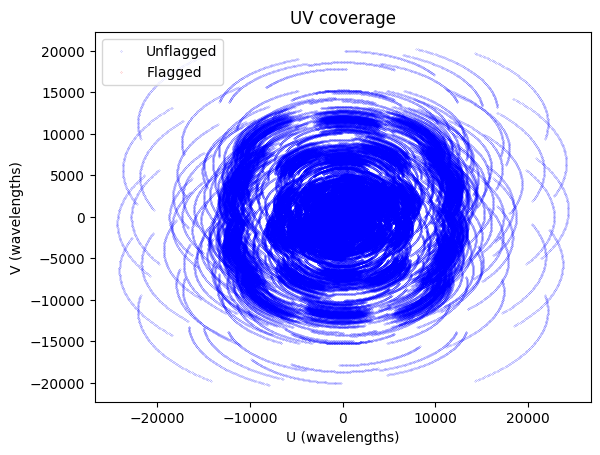

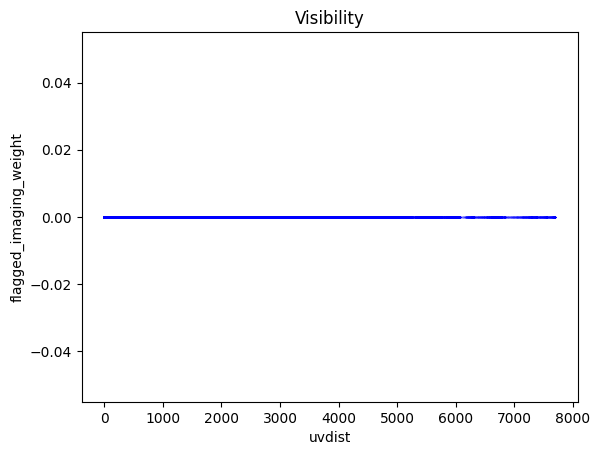

In [48]:
plot_uvcoverage([vt])
plot_visibility([vt],y='flagged_imaging_weight')

### Fill visibilities amplitude from (Fourier plane values) of image in FITS file. Cell size corresponds to the (advised) pixel angular size in radians. Uses Nifty gridder.

In [44]:
#vt, cell_size, im = visibilities_from_image(vt,'data/Meerkat_Galactic_center_512_ext.fits',return_cellsize=True,return_image=True)
vt, cell_size, im = visibilities_from_image(vt,'data/toto_ext.fits',return_cellsize=True,return_image=True,scale_factor=2.)

advise_wide_field: (max_wavelength) Maximum wavelength 0.300 (meters)
advise_wide_field: (min_wavelength) Minimum wavelength 0.300 (meters)
advise_wide_field: (maximum_baseline) Maximum baseline 24331.5 (wavelengths)
advise_wide_field: (maximum_w) Maximum w 10597.6 (wavelengths)
advise_wide_field: (diameter) Station/dish diameter 13.5 (meters)
advise_wide_field: (primary_beam_fov) Primary beam 0.0222 (rad) 1.27 (deg) 4.58e+03 (asec)
advise_wide_field: (image_fov) Image field of view 0.0666 (rad) 3.82 (deg) 1.37e+04 (asec)
advise_wide_field: (synthesized_beam) Synthesized beam 4.11e-05 (rad) 0.00235 (deg) 8.48 (asec)
advise_wide_field: (cellsize) Cellsize 1.03e-05 (rad) 0.000589 (deg) 2.12 (asec)
advice_wide_field: (npixels) Npixels per side = 6484
advice_wide_field: (npixels2) Npixels (power of 2) per side = 8192
advice_wide_field: (npixels23) Npixels (power of 2, 3) per side = 8192
advice_wide_field: (npixels_min) Npixels (power of 2, 3, 4, 5) per side = 6561

advice_wide_field: (w_sa

### Plot visibility amplitudes as a function of uv radius

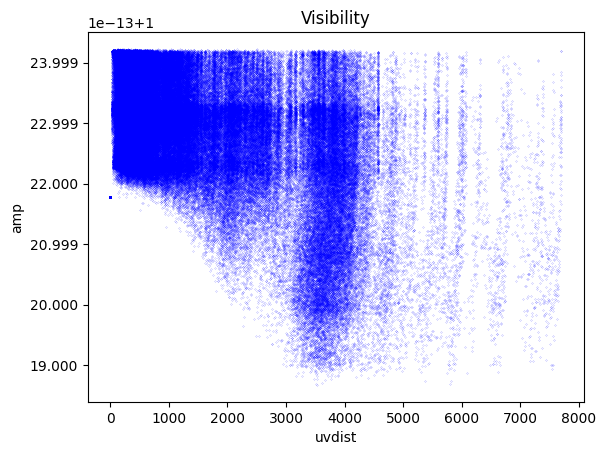

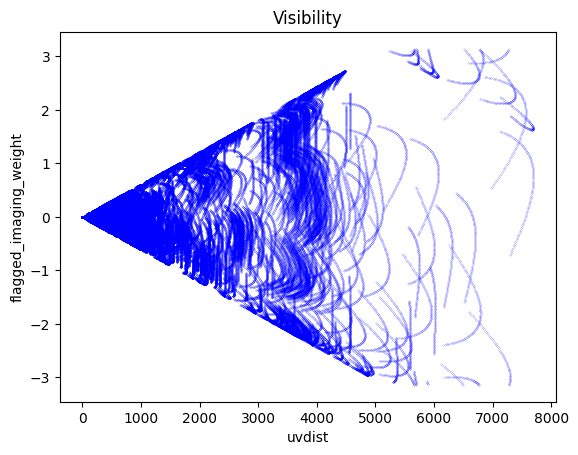

In [45]:
plot_visibility([vt])
plot_visibility([vt],y='flagged_imaging_weight')

### Create empty (rascil) image from visibility metadata. Then predict dirty and psf images using nifty gridder (adjoint)

In [6]:
dirty, psf = dirty_psf_from_visibilities(vt,cell_size,npix=512)

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (56., -30.)>, starting frequency 1000000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 24331.536075 wavelengths
create_image_from_visibility: Critical cellsize = 0.000021 radians, 0.001177 degrees
create_image_from_visibility: Cellsize = 2.05495e-05 radians, 0.0011774 degrees
create_image_from_visibility: image shape is (1, 1, 512, 512)
Model image plate scale (arcsec) is -4.238631e+00


### Visualize original image, dirty image and psf

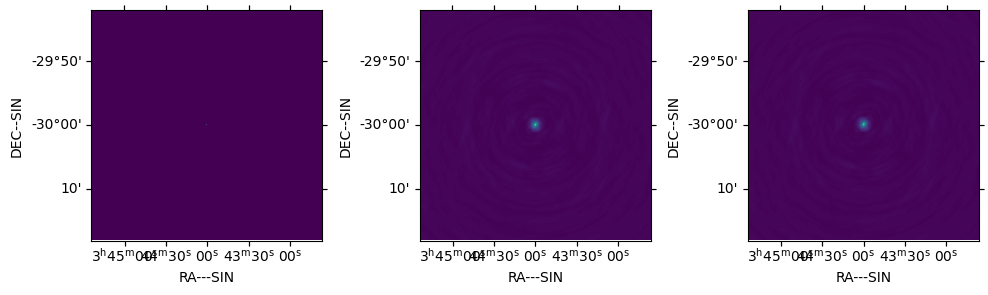

In [7]:
#show_image(im,cm=cmap)
#show_image(dirty,cm=cmap)
#show_image(psf,cm=cmap)
fig = plt.figure(figsize=(12,3))
ax=fig.add_subplot(1,3,1,projection=im.image_acc.wcs.sub([1, 2]))
ax.imshow(im.pixels.data[0,0,:,:],origin='lower',cmap=cmap)
ax.set_xlabel(im.image_acc.wcs.wcs.ctype[0])
ax.set_ylabel(im.image_acc.wcs.wcs.ctype[1])

ax=fig.add_subplot(1,3,2,projection=dirty.image_acc.wcs.sub([1, 2]))
ax.imshow(dirty.pixels.data[0,0,:,:],origin='lower',cmap=cmap)
ax.set_xlabel(dirty.image_acc.wcs.wcs.ctype[0])
ax.set_ylabel(dirty.image_acc.wcs.wcs.ctype[1])

ax=fig.add_subplot(1,3,3,projection=psf.image_acc.wcs.sub([1, 2]))
ax.imshow(psf.pixels.data[0,0,:,:],origin='lower',cmap=cmap)
ax.set_xlabel(psf.image_acc.wcs.wcs.ctype[0])
ax.set_ylabel(psf.image_acc.wcs.wcs.ctype[1])



In [8]:
dirty.image_acc.export_to_fits('data/dirty_ps.fits')
psf.image_acc.export_to_fits('data/psf.fits')

(-0.05, 1.0)

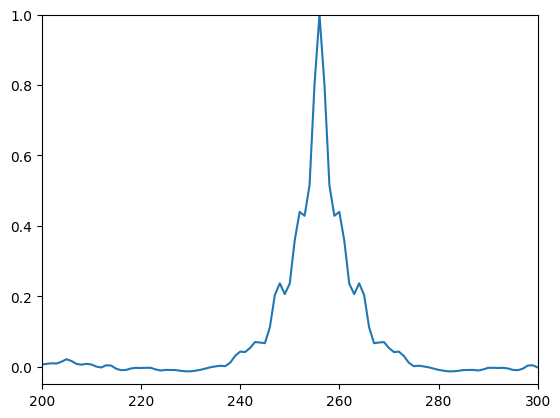

In [9]:
plt.plot(psf['pixels'].data[0,0,256,:])
plt.xlim((200,300)); plt.ylim((-0.05,1))

In [10]:
psf['pixels'].data.shape

(1, 1, 512, 512)

In [11]:
uv_psf = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(psf.pixels.data.squeeze())))

In [12]:
uv_psf.shape

(512, 512)

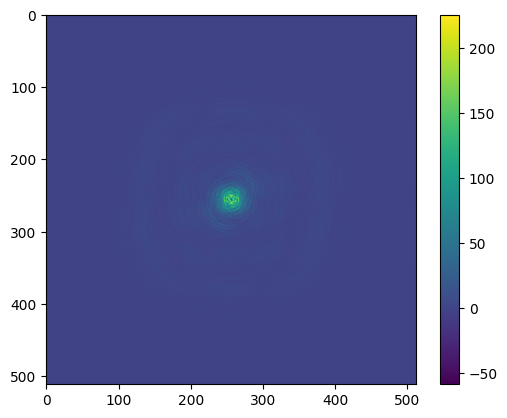

In [13]:
plt.imshow(np.real(uv_psf))
plt.colorbar()

In [17]:
from astropy.io import fits as pyfits
hdu = pyfits.PrimaryHDU(np.real(uv_psf))
hdu.writeto("uv_psf.fits")

In [18]:
from ska_sdp_func_python.imaging import invert_ng, predict_ng, \
     create_image_from_visibility, advise_wide_field 

In [20]:
model = create_image_from_visibility(vt,cellsize=cell_size,npixel=512)

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (56., -30.)>, starting frequency 1000000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 24331.536075 wavelengths
create_image_from_visibility: Critical cellsize = 0.000021 radians, 0.001177 degrees
create_image_from_visibility: Cellsize = 2.05495e-05 radians, 0.0011774 degrees
create_image_from_visibility: image shape is (1, 1, 512, 512)


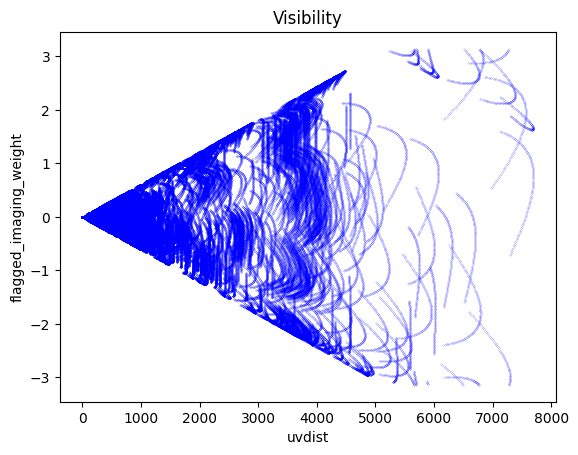

In [36]:
plot_visibility([vt],y='flagged_imaging_weight')

array([[[[1.        -7.76886112e-14j]],

        [[0.9998698 +1.61365767e-02j]],

        [[0.99999681-2.52525082e-03j]],

        ...,

        [[1.        -7.76886112e-14j]],

        [[0.64014348+7.68255379e-01j]],

        [[1.        -7.76886112e-14j]]],


       [[[1.        -7.76886112e-14j]],

        [[0.99987101+1.60615600e-02j]],

        [[0.99999707-2.42190000e-03j]],

        ...,

        [[1.        -7.76886112e-14j]],

        [[0.63543332+7.72155747e-01j]],

        [[1.        -7.76886112e-14j]]],


       [[[1.        -7.76886112e-14j]],

        [[0.99987221+1.59861895e-02j]],

        [[0.99999731-2.31877924e-03j]],

        ...,

        [[1.        -7.76886112e-14j]],

        [[0.6307389 +7.75995126e-01j]],

        [[1.        -7.76886112e-14j]]],


       ...,


       [[[1.        -7.76886112e-14j]],

        [[0.99997842+6.57017522e-03j]],

        [[0.99998084+6.19031459e-03j]],

        ...,

        [[1.        -7.76886112e-14j]],

        [[0.39952664+9